In [4]:
import os
import ast
import glob
import json
import shutil
import random
import numpy as np
import pandas as pd
import seaborn as sns
from random import shuffle
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

### Rename images

In [49]:
# Path to the main directory containing subfolders
main_dir = 'C:/Users/m294666/Documents/nevus_data_500_risk_factors_processed'

# Path to the Excel file
excel_file_path = 'C:/Users/m294666/Documents/nevus_data/230929_Ch_Nevus_deleted_items_to_ignore.xlsx'

# Load the Excel file into a pandas DataFrame
df = pd.read_excel(excel_file_path)

# Iterate over each subfolder in the main directory
for folder_name in os.listdir(main_dir):
    folder_path = os.path.join(main_dir, folder_name)

    # Check if the item in the directory is a subfolder
    if os.path.isdir(folder_path):
        # Get the MRN value from the folder name
        mrn = folder_name

        # Find the corresponding row in the Excel file based on MRN
        row = df[df['MRN'].astype(str) == mrn]

        # Check if there is a matching row in the Excel file
        if not row.empty:
            affected_eye = row['Affected Eye'].values[0]
            
            l,r = 0,0

            # Iterate over each file in the subfolder
            for i,filename in enumerate(os.listdir(folder_path)):
                
                if os.path.isfile(os.path.join(folder_path, filename)):
                    # Check the affected eye and rename the file accordingly
                    if affected_eye == 'Left':
                        new_filename = f'{mrn}_L_{i}.jpg'
                    elif affected_eye == 'Right':
                        new_filename = f'{mrn}_R_{i}.jpg'
                    elif affected_eye == 'Both':
                        if filename.endswith('_L.jpg'):
                            new_filename = f'{mrn}_L_{l}.jpg'
                            l +=1 
                        elif filename.endswith('_R.jpg'):
                            new_filename = f'{mrn}_R_{r}.jpg'
                            r += 1
                        else:
                            # Handle other cases as needed
                            new_filename = filename
                    else:
                        # Handle other cases as needed
                        new_filename = filename

                    # Rename the file
                    os.rename(os.path.join(folder_path, filename), os.path.join(folder_path, new_filename))

### Create directories for RETFound (dia5)

In [50]:
# Function to create directories
def create_directories(base_path, folders):
    for folder in folders:
        folder_path = os.path.join(base_path, folder)
        os.makedirs(folder_path, exist_ok=True)
        os.makedirs(os.path.join(folder_path, '0'), exist_ok=True)
        os.makedirs(os.path.join(folder_path, '1'), exist_ok=True)

mrn_directory_path = 'C:/Users/m294666/Documents/nevus_data_500_risk_factors_processed'

base_directory_path = 'C:/Users/m294666/Documents/data_dia5_retfound'

# Delete the contents of the main directory if it is not empty
shutil.rmtree(base_directory_path, ignore_errors=True)

# Create train, val, and test directories
create_directories(base_directory_path, ['train', 'val', 'test'])

# Specify the path to your Excel file
excel_file_path = 'C:/Users/m294666/Documents/nevus_data/230929_Ch_Nevus_deleted_items_to_ignore.xlsx'

# Load the Excel file into a pandas DataFrame
df = pd.read_excel(excel_file_path)

# Function to determine set (train, val, test) for each MRN
def determine_set(mrn_list):
    random.shuffle(mrn_list)
    total_mrn = len(mrn_list)
    train_size = int(0.6 * total_mrn)
    val_size = int(0.2 * total_mrn)
    
    train_set = mrn_list[:train_size]
    val_set = mrn_list[train_size:train_size + val_size]
    test_set = mrn_list[train_size + val_size:]
    
    return train_set, val_set, test_set

# Function to copy images based on diameter condition
def copy_images(source_path, dest_path, mrn, set_type, df):
    
    mrn_row = df[df['MRN'].astype(str) == mrn]
    
    for image_name in os.listdir(os.path.join(source_path, mrn)):
        diameter_column = 'OD Largest tumor diameter (mm)' if '_R' in image_name else 'OS Largest tumor diameter (mm)'
        diameter = mrn_row[diameter_column].iloc[0]
        if diameter > 5.0:
            shutil.copy(os.path.join(source_path, mrn, image_name), os.path.join(dest_path, set_type, '1'))
        else:
            shutil.copy(os.path.join(source_path, mrn, image_name), os.path.join(dest_path, set_type, '0'))

# Get the list of MRNs from the MRN directory
mrn_list = os.listdir(mrn_directory_path)

# Split MRNs into train, val, test sets
train_set, val_set, test_set = determine_set(mrn_list)

# Iterate over each MRN folder and copy images based on the specified conditions
for mrn in mrn_list:
    if mrn in train_set:
        copy_images(mrn_directory_path, base_directory_path, mrn, 'train', df)
    elif mrn in val_set:
        copy_images(mrn_directory_path, base_directory_path, mrn, 'val', df)
    elif mrn in test_set:
        copy_images(mrn_directory_path, base_directory_path, mrn, 'test', df)

In [27]:
# # Perform train/val/test split
# train_df = filtered_df.sample(frac=0.6, random_state=1)
# val_test_df = filtered_df.drop(train_df.index)
# val_df = val_test_df.sample(frac=0.5, random_state=1)
# test_df = val_test_df.drop(val_df.index)

# # Define a function to copy images based on 'dia>5' column
# def copy_images(source_folder, destination_folder, mrn_list, dia_value):
#     dia_value = dia_value.astype(str).tolist()
#     for i,mrn in enumerate(mrn_list):
#         source_path = os.path.join(source_folder, str(mrn))
#         destination_path = os.path.join(destination_folder, dia_value[i])
#         os.makedirs(destination_path, exist_ok=True)
#         files = os.listdir(source_path)
#         for file in files:
#             shutil.copy(os.path.join(source_path, file), destination_path)

# # Copy images for the train set
# copy_images(mrn_directory_path, os.path.join(base_directory_path, 'train'), train_df['MRN'], train_df['dia>5'].astype(str))

# # Copy images for the val set
# copy_images(mrn_directory_path, os.path.join(base_directory_path, 'val'), val_df['MRN'], val_df['dia>5'].astype(str))

# # Copy images for the test set
# copy_images(mrn_directory_path, os.path.join(base_directory_path, 'test'), test_df['MRN'], test_df['dia>5'].astype(str))

### Create directories for RETFound (thick2)

In [65]:
# Function to create directories
def create_directories(base_path, folders):
    for folder in folders:
        folder_path = os.path.join(base_path, folder)
        os.makedirs(folder_path, exist_ok=True)
        os.makedirs(os.path.join(folder_path, '0'), exist_ok=True)
        os.makedirs(os.path.join(folder_path, '1'), exist_ok=True)

mrn_directory_path = 'C:/Users/m294666/Documents/nevus_data_500_risk_factors_processed'

base_directory_path = 'C:/Users/m294666/Documents/data_thick2_retfound'

# Delete the contents of the main directory if it is not empty
shutil.rmtree(base_directory_path, ignore_errors=True)

# Create train, val, and test directories
create_directories(base_directory_path, ['train', 'val', 'test'])

# Specify the path to your Excel file
excel_file_path = 'C:/Users/m294666/Documents/nevus_data/230929_Ch_Nevus_deleted_items_to_ignore.xlsx'

# Load the Excel file into a pandas DataFrame
df = pd.read_excel(excel_file_path)

# Function to determine set (train, val, test) for each MRN
def determine_set(mrn_list):
    random.shuffle(mrn_list)
    total_mrn = len(mrn_list)
    train_size = int(0.6 * total_mrn)
    val_size = int(0.2 * total_mrn)
    
    train_set = mrn_list[:train_size]
    val_set = mrn_list[train_size:train_size + val_size]
    test_set = mrn_list[train_size + val_size:]
    
    return train_set, val_set, test_set

# Function to copy images based on diameter condition
def copy_images(source_path, dest_path, mrn, set_type, df):
    
    mrn_row = df[df['MRN'].astype(str) == mrn]
    
    for image_name in os.listdir(os.path.join(source_path, mrn)):
        column = 'OD Largest tumor thickness (mm)' if '_R' in image_name else 'OS Largest tumor thickness (mm)'
        thickness = mrn_row[column].iloc[0]
        if thickness > 2.0:
            shutil.copy(os.path.join(source_path, mrn, image_name), os.path.join(dest_path, set_type, '1'))
        else:
            shutil.copy(os.path.join(source_path, mrn, image_name), os.path.join(dest_path, set_type, '0'))

# Get the list of MRNs from the MRN directory
mrn_list = os.listdir(mrn_directory_path)

# Split MRNs into train, val, test sets
train_set, val_set, test_set = determine_set(mrn_list)

# Iterate over each MRN folder and copy images based on the specified conditions
for mrn in mrn_list:
    if mrn in train_set:
        copy_images(mrn_directory_path, base_directory_path, mrn, 'train', df)
    elif mrn in val_set:
        copy_images(mrn_directory_path, base_directory_path, mrn, 'val', df)
    elif mrn in test_set:
        copy_images(mrn_directory_path, base_directory_path, mrn, 'test', df)

### Create directories for RETFound (srf)

In [68]:
# Function to create directories
def create_directories(base_path, folders):
    for folder in folders:
        folder_path = os.path.join(base_path, folder)
        os.makedirs(folder_path, exist_ok=True)
        os.makedirs(os.path.join(folder_path, '0'), exist_ok=True)
        os.makedirs(os.path.join(folder_path, '1'), exist_ok=True)

mrn_directory_path = 'C:/Users/m294666/Documents/nevus_data_500_risk_factors_processed'

base_directory_path = 'C:/Users/m294666/Documents/data_srf_retfound'

# Delete the contents of the main directory if it is not empty
shutil.rmtree(base_directory_path, ignore_errors=True)

# Create train, val, and test directories
create_directories(base_directory_path, ['train', 'val', 'test'])

# Specify the path to your Excel file
excel_file_path = 'C:/Users/m294666/Documents/nevus_data/230929_Ch_Nevus_deleted_items_to_ignore.xlsx'

# Load the Excel file into a pandas DataFrame
df = pd.read_excel(excel_file_path)

# Function to determine set (train, val, test) for each MRN
def determine_set(mrn_list):
    random.shuffle(mrn_list)
    total_mrn = len(mrn_list)
    train_size = int(0.6 * total_mrn)
    val_size = int(0.2 * total_mrn)
    
    train_set = mrn_list[:train_size]
    val_set = mrn_list[train_size:train_size + val_size]
    test_set = mrn_list[train_size + val_size:]
    
    return train_set, val_set, test_set

# Function to copy images based on diameter condition
def copy_images(source_path, dest_path, mrn, set_type, df):
    
    mrn_row = df[df['MRN'].astype(str) == mrn]
    
    for image_name in os.listdir(os.path.join(source_path, mrn)):
        column = 'OD SRF in fov' if '_R' in image_name else 'OS SRF in fov'
        srf = mrn_row[column].iloc[0]
        if srf:
            shutil.copy(os.path.join(source_path, mrn, image_name), os.path.join(dest_path, set_type, '1'))
        else:
            shutil.copy(os.path.join(source_path, mrn, image_name), os.path.join(dest_path, set_type, '0'))

# Get the list of MRNs from the MRN directory
mrn_list = os.listdir(mrn_directory_path)

# Split MRNs into train, val, test sets
train_set, val_set, test_set = determine_set(mrn_list)

# Iterate over each MRN folder and copy images based on the specified conditions
for mrn in mrn_list:
    if mrn in train_set:
        copy_images(mrn_directory_path, base_directory_path, mrn, 'train', df)
    elif mrn in val_set:
        copy_images(mrn_directory_path, base_directory_path, mrn, 'val', df)
    elif mrn in test_set:
        copy_images(mrn_directory_path, base_directory_path, mrn, 'test', df)

### Create directories for RETFound (orange pigment)

In [124]:
# Function to create directories
def create_directories(base_path, folders):
    for folder in folders:
        folder_path = os.path.join(base_path, folder)
        os.makedirs(folder_path, exist_ok=True)
        os.makedirs(os.path.join(folder_path, '0'), exist_ok=True)
        os.makedirs(os.path.join(folder_path, '1'), exist_ok=True)

mrn_directory_path = 'C:/Users/m294666/Documents/nevus_data_500_risk_factors_processed'

base_directory_path = 'C:/Users/m294666/Documents/data_orange_retfound'

# Delete the contents of the main directory if it is not empty
shutil.rmtree(base_directory_path, ignore_errors=True)

# Create train, val, and test directories
create_directories(base_directory_path, ['train', 'val', 'test'])

# Specify the path to your Excel file
excel_file_path = 'C:/Users/m294666/Documents/nevus_data/230929_Ch_Nevus_deleted_items_to_ignore.xlsx'

# Load the Excel file into a pandas DataFrame
df = pd.read_excel(excel_file_path)

# Function to determine set (train, val, test) for each MRN
def determine_set(mrn_list):
    random.shuffle(mrn_list)
    total_mrn = len(mrn_list)
    train_size = int(0.6 * total_mrn)
    val_size = int(0.2 * total_mrn)
    
    train_set = mrn_list[:train_size]
    val_set = mrn_list[train_size:train_size + val_size]
    test_set = mrn_list[train_size + val_size:]
    
    return train_set, val_set, test_set

# Function to copy images based on diameter condition
def copy_images(source_path, dest_path, mrn, set_type, df):
    
    mrn_row = df[df['MRN'].astype(str) == mrn]
    
    for image_name in os.listdir(os.path.join(source_path, mrn)):
        column = 'OD Orange pigment' if '_R' in image_name else 'OS Orange pigment'
        orange = mrn_row[column].iloc[0]
        if orange:
            shutil.copy(os.path.join(source_path, mrn, image_name), os.path.join(dest_path, set_type, '1'))
        else:
            shutil.copy(os.path.join(source_path, mrn, image_name), os.path.join(dest_path, set_type, '0'))

# Get the list of MRNs from the MRN directory
mrn_list = os.listdir(mrn_directory_path)

# Split MRNs into train, val, test sets
train_set, val_set, test_set = determine_set(mrn_list)

# Iterate over each MRN folder and copy images based on the specified conditions
for mrn in mrn_list:
    if mrn in train_set:
        copy_images(mrn_directory_path, base_directory_path, mrn, 'train', df)
    elif mrn in val_set:
        copy_images(mrn_directory_path, base_directory_path, mrn, 'val', df)
    elif mrn in test_set:
        copy_images(mrn_directory_path, base_directory_path, mrn, 'test', df)

### Create directories for RETFound (internal reflectivity)

In [126]:
# Function to create directories
def create_directories(base_path, folders):
    for folder in folders:
        folder_path = os.path.join(base_path, folder)
        os.makedirs(folder_path, exist_ok=True)
        os.makedirs(os.path.join(folder_path, '0'), exist_ok=True)
        os.makedirs(os.path.join(folder_path, '1'), exist_ok=True)

mrn_directory_path = 'C:/Users/m294666/Documents/nevus_data_500_risk_factors_processed'

base_directory_path = 'C:/Users/m294666/Documents/data_intref_retfound'

# Delete the contents of the main directory if it is not empty
shutil.rmtree(base_directory_path, ignore_errors=True)

# Create train, val, and test directories
create_directories(base_directory_path, ['train', 'val', 'test'])

# Specify the path to your Excel file
excel_file_path = 'C:/Users/m294666/Documents/nevus_data/230929_Ch_Nevus_deleted_items_to_ignore.xlsx'

# Load the Excel file into a pandas DataFrame
df = pd.read_excel(excel_file_path)

# Function to determine set (train, val, test) for each MRN
def determine_set(mrn_list):
    random.shuffle(mrn_list)
    total_mrn = len(mrn_list)
    train_size = int(0.6 * total_mrn)
    val_size = int(0.2 * total_mrn)
    
    train_set = mrn_list[:train_size]
    val_set = mrn_list[train_size:train_size + val_size]
    test_set = mrn_list[train_size + val_size:]
    
    return train_set, val_set, test_set

# Function to copy images based on diameter condition
def copy_images(source_path, dest_path, mrn, set_type, df):
    
    mrn_row = df[df['MRN'].astype(str) == mrn]
    
    for image_name in os.listdir(os.path.join(source_path, mrn)):
        column = 'OD Internal reflectivity' if '_R' in image_name else 'OS Internal reflectivity'
        int_ref = (True if mrn_row[column].iloc[0] in ['Low', 'Medium'] else False)
        if int_ref:
            shutil.copy(os.path.join(source_path, mrn, image_name), os.path.join(dest_path, set_type, '1'))
        else:
            shutil.copy(os.path.join(source_path, mrn, image_name), os.path.join(dest_path, set_type, '0'))

# Get the list of MRNs from the MRN directory
mrn_list = os.listdir(mrn_directory_path)

# Split MRNs into train, val, test sets
train_set, val_set, test_set = determine_set(mrn_list)

# Iterate over each MRN folder and copy images based on the specified conditions
for mrn in mrn_list:
    if mrn in train_set:
        copy_images(mrn_directory_path, base_directory_path, mrn, 'train', df)
    elif mrn in val_set:
        copy_images(mrn_directory_path, base_directory_path, mrn, 'val', df)
    elif mrn in test_set:
        copy_images(mrn_directory_path, base_directory_path, mrn, 'test', df)

### Create CSV file for CNN-based approach

In [64]:
def process_images(main_dir, excel_path, output_csv_path):
    # Get all MRNs (group names from main_dir)
    mrns = [folder for folder in os.listdir(main_dir) if os.path.isdir(os.path.join(main_dir, folder))]

    # Create a new dataframe with two columns, 'Image Path' and 'Label'
    output_data = []

    # Load excel file
    excel_data = pd.read_excel(excel_path)

    # Iterate over each folder
    for mrn in mrns:
        folder_path = os.path.join(main_dir, mrn)

        # The first row of the excel file contains MRNs. Use the MRN to get the row
        mrn_row = excel_data[excel_data['MRN'].astype(str) == mrn]

        # iterate over all the images in the folder
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)

            # If image name contains '_R', then get diameter from 'OD Largest tumor diameter (mm)' column,
            # else get it from 'OS Largest tumor diameter (mm)'
            if '_R' in image_name:
                diameter = mrn_row['OD Largest tumor diameter (mm)'].values[0]
            else:
                diameter = mrn_row['OS Largest tumor diameter (mm)'].values[0]

            # If diameter is greater than 5.0, save the path of the image in 'Image Path' and 1 in 'Label'
            # If diameter is less than 5.0, save the path of image in 'Image Path' and 0 in 'Label'
            label = 1 if diameter > 5.0 else 0

            # Replace 'C:/Users/m294666/Documents/' in image path with '/research/labs/ophthalmology/iezzi/m294666/'
            image_path = image_path.replace('C:/Users/m294666/Documents/', '/research/labs/ophthalmology/iezzi/m294666/').replace('\\', '/')

            # Append to the dataframe
            output_data.append({'Image Path': image_path, 'Label': label})

    output_df = pd.DataFrame(output_data)
    
    # Save the dataframe to CSV
    output_df.to_csv(output_csv_path, index=False)
    print(f"Output CSV saved to: {output_csv_path}")

# Example usage:
main_directory = 'C:/Users/m294666/Documents/nevus_data_500_risk_factors_processed'
excel_file_path = 'C:/Users/m294666/Documents/nevus_data/230929_Ch_Nevus_deleted_items_to_ignore.xlsx'
output_csv_file_path = 'C:/Users/m294666/Documents/nevus_data_500_for_resnet.csv'

process_images(main_directory, excel_file_path, output_csv_file_path)

Output CSV saved to: C:/Users/m294666/Documents/nevus_data_500_for_resnet.csv


### Count total images in given directory

In [8]:
def count_images(directory_path, image_extensions=('jpg', 'jpeg', 'png', 'gif')):
    # Ensure the directory path ends with a slash
    directory_path = os.path.join(directory_path, '')

    # Use glob to get a list of files matching the specified extensions recursively
    image_files = []
    for extension in image_extensions:
        pattern = directory_path + f'**/*.{extension}'
        image_files.extend(glob.glob(pattern, recursive=True))

    # Count the number of image files
    num_images = len(image_files)

    return num_images, image_files

# directory_path = 'C:/Users/m294666/Documents/nevus_data_500_risk_factors'
directory_path = 'C:/Users/m294666/Documents/nevus_data_500_risk_factors'
num_images, image_files = count_images(directory_path)

print(f"Number of images in '{directory_path}': {num_images}")

Number of images in 'C:/Users/m294666/Documents/nevus_data_500_risk_factors': 520


### Find max images in a folder

In [17]:
import os

def count_images_in_folder(folder_path):
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']  # Add more extensions if needed
    image_count = 0

    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        if os.path.isfile(file_path) and any(file_name.lower().endswith(ext) for ext in image_extensions):
            image_count += 1

    return image_count

def top_n_folders_with_images(main_directory, n):
    folder_image_count = []

    for subfolder_name in os.listdir(main_directory):
        subfolder_path = os.path.join(main_directory, subfolder_name)
        if os.path.isdir(subfolder_path):
            image_count = count_images_in_folder(subfolder_path)
            folder_image_count.append((subfolder_name, image_count))

    # Sort the folders based on image count in descending order
    sorted_folders = sorted(folder_image_count, key=lambda x: x[1], reverse=True)

    # Display the top N folders
    for i in range(min(n, len(sorted_folders))):
        folder_name, image_count = sorted_folders[i]
        print(f"{folder_name}: {image_count} images")

# Example usage
main_directory_path = "C:/Users/m294666/Documents/nevus_data_500_risk_factors"
top_n_folders_with_images(main_directory_path, 10)

12252292: 4 images
1455618: 4 images
1767396: 4 images
2007399: 4 images
2248076: 4 images
2578116: 4 images
1770547: 3 images
2439833: 3 images
2498796: 3 images
2635577: 3 images


### Get RF counts

In [122]:
excel_file_path = 'C:/Users/m294666/Documents/nevus_data/230929_Ch_Nevus_deleted_items_to_ignore.xlsx'

# Initialize counters
yes_count = 0
no_count = 0

df = pd.read_excel(excel_file_path)

# rf = 'Largest tumor diameter (mm)'
# rf = 'Largest tumor thickness (mm)'
# rf = 'Orange pigment'
# rf = 'SRF in fov'
# rf = 'Internal reflectivity'
rf = 'VA at DFS (Snellen)'
amount = 2.0

for index, row in df.iterrows():
    
#     print(row['OD ' + rf], row['OS ' + rf])
    
    affected_eye = row['Affected Eye']
#     print(pd.isna(row['OD ' + rf]), pd.isna(row['OS ' + rf]))
    if affected_eye == 'Right':

#         if row['OD ' + rf] > amount:
#         if row['OD ' + rf]:
#         if row['OD ' + rf] in ['Low', 'Medium']:
        if int(row['OD ' + rf].split('/')[-1]) >= 50:
            yes_count += 1
        else: no_count += 1
            
    elif affected_eye == 'Left':

#         if row['OS ' + rf] > amount:
#         if row['OS ' + rf]:
#         if row['OS ' + rf] in ['Low', 'Medium']:
        if int(row['OS ' + rf].split('/')[-1]) >= 50:
            yes_count += 1
        else: no_count += 1
            
    elif affected_eye == 'Both':

#         if row['OD ' + rf] > amount:
#         if row['OD ' + rf]:
#         if row['OD ' + rf] in ['Low', 'Medium']:
        if int(row['OD ' + rf].split('/')[-1]) >= 50:
            yes_count += 1
        else: no_count += 1

#         if row['OS ' + rf] > amount:
#         if row['OS ' + rf]:
#         if row['OS ' + rf] in ['Low', 'Medium']:
        if int(row['OS ' + rf].split('/')[-1]) >= 50:
            yes_count += 1
        else: no_count += 1
            
print(f'{rf} yes: {yes_count}')
print(f'{rf} no: {no_count}')

VA at DFS (Snellen) yes: 34
VA at DFS (Snellen) no: 499


In [114]:
test = '20/50'
int(test.split('/')[-1])

50

### Move diabetic retinopathy label 0 images to new folder to test RF models

In [4]:
import pandas as pd
import shutil
import os

def copy_images_with_label(csv_path, images_folder, destination_folder):
    # Read CSV file into a DataFrame
    df = pd.read_csv(csv_path)

    # Filter rows with label 0
    label_0_images = df[df['Label'] == 0]['Image Path'].tolist()

    # Ensure destination folder exists
    os.makedirs(destination_folder, exist_ok=True)

    # Copy images with label 0 to the destination folder
    for image_name in label_0_images:
        source_path = images_folder + '/' + image_name + '.jpeg'
        destination_path = destination_folder + '/' + image_name + '.jpeg'
        shutil.copy2(source_path, destination_path)

# Replace these paths with your actual paths
csv_path = 'C:/Users/m294666/Documents/diaret_dataset/diaret_labels.csv'
images_folder = 'C:/Users/m294666/Documents/diaret_dataset/resized_train_cropped/resized_train_cropped'
destination_folder = 'C:/Users/m294666/Documents/diaret_0_for_rf_testing/test/0'

# Call the function
copy_images_with_label(csv_path, images_folder, destination_folder)


### Rename images to contain MRN_L/R_image no_RF1_ ... _ RF6

In [41]:
# Path to the main directory containing subfolders
main_folder_path = 'C:/Users/m294666/Documents/nevus_data_500_risk_factors_processed_RF_in_name_Copy'

# Path to the Excel file
excel_path = 'C:/Users/m294666/Documents/nevus_data/230929_Ch_Nevus_deleted_items_to_ignore.xlsx'

# Load the Excel file into a pandas DataFrame
df = pd.read_excel(excel_path)

r1, r2, r3, r4, r5, r6 = 0,0,0,0,0,0

# Iterate over each sub-folder in the main folder
for sub_folder in os.listdir(main_folder_path):
    sub_folder_path = os.path.join(main_folder_path, sub_folder)

    # Check if the sub-folder is actually a folder
    if os.path.isdir(sub_folder_path):
        # Extract MRN from the sub-folder name
        mrn = sub_folder

        # Iterate over each image in the sub-folder
        for image_name in os.listdir(sub_folder_path):
            image_path = os.path.join(sub_folder_path, image_name)

            # Extract side (OD or OS) from the image name
            side = "OD" if "R" in image_name else "OS"

            # Filter the DataFrame based on MRN
            mrn_row = df[df['MRN'].astype(str) == mrn]

            # Check if the MRN exists in the Excel file
            if not mrn_row.empty:
                
                RF_1 = f'{side} Largest tumor diameter (mm)' 
                RF_2 = f'{side} Internal reflectivity' 
                RF_3 = f'{side} Orange pigment' 
                RF_4 = f'{side} VA at DFS (Snellen)' 
                RF_5 = f'{side} Largest tumor thickness (mm)' 
                RF_6 = f'{side} SRF in fov'
                
                # print(mrn_row[RF_1].iloc[0])
                # print(mrn_row[RF_2].iloc[0])
                # print(mrn_row[RF_3].iloc[0])
                # print(mrn_row[RF_4].iloc[0])
                # print(mrn_row[RF_5].iloc[0])
                # print(mrn_row[RF_6].iloc[0])
                
                # RF 1: Dia > 5
                if mrn_row[RF_1].iloc[0] > 5.0: rf1_name = 1
                else: rf1_name = 0
                
                # RF 2: Internal reflectivity
                if mrn_row[RF_2].iloc[0] in ['Low', 'Medium']: rf2_name = 1
                else: rf2_name = 0
                    
                # RF 3: Orange pigment
                if mrn_row[RF_3].iloc[0]: rf3_name = 1
                else: rf3_name = 0
                
                # RF4: Visual Acuity
                if int(mrn_row[RF_4].iloc[0].split('/')[-1]) >= 50: rf4_name = 1
                else: rf4_name = 0
                    
                # RF5: thickness > 2
                if mrn_row[RF_5].iloc[0] > 2.0: rf5_name = 1
                else: rf5_name = 0
                
                # RF6: SRF
                if mrn_row[RF_6].iloc[0]: rf6_name = 1
                else: rf6_name = 0
                    
                r1 += rf1_name
                r2 += rf2_name
                r3 += rf3_name
                r4 += rf4_name
                r5 += rf5_name
                r6 += rf6_name
                    
                # print(rf1_name, rf2_name, rf3_name, rf4_name, rf5_name, rf6_name)

                # Combine side and specific columns to create a new name
                side = image_name.split('_')[1]
                side_no = image_name.split('_')[2]
                new_name = f"{mrn}_{side}_{side_no}_{rf1_name}_{rf2_name}_{rf3_name}_{rf4_name}_{rf5_name}_{rf6_name}{image_name[-4:]}"

                # Rename the image
                new_image_path = os.path.join(sub_folder_path, new_name)
                os.rename(image_path, new_image_path)
                # print(f"Renamed: {image_path} to {new_image_path}")
            else:
                pass
                # print(f"MRN {mrn} not found in Excel file for image {image_name}")
                
print(r1,r2,r3,r4,r5,r6)

250 158 67 29 28 15


### Get RF position in name

In [47]:
img = 'C:/Users/m294666/Documents/nevus_data_500_risk_factors_processed_RF_in_name\9987820\9987820_R_0_1_0_0_0_0_0.jpg'

rf1 = img.split('.')[0].split('_')[-6]
rf2 = img.split('.')[0].split('_')[-5]
rf3 = img.split('.')[0].split('_')[-4]
rf4 = img.split('.')[0].split('_')[-3]
rf5 = img.split('.')[0].split('_')[-2]
rf6 = img.split('.')[0].split('_')[-1]

print(rf1,rf2,rf3,rf4,rf5,rf6)

1 0 0 0 0 0


### Create function for k-fold cross validation

In [57]:
def split_folders(directory_path):
    # Get the list of folder names in the specified directory
    folder_names = [folder for folder in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, folder))]

    # Shuffle the list of folder names for random splitting
    shuffle(folder_names)

    # Calculate the split indices for 80/20 split and 5 equal sets
    split_index_80_20 = int(0.8 * len(folder_names))
    split_indices_5_sets = [int(i * split_index_80_20 / 5) for i in range(1, 5)]

    # Divide the folder names into train_val and test lists
    train_val = folder_names[:split_index_80_20]
    test = folder_names[split_index_80_20:]

    # Split the train_val into 5 equal sets
    train_val_sets = [train_val[i:j] for i, j in zip([0] + split_indices_5_sets, split_indices_5_sets + [None])]

    return train_val_sets, test

# Example usage:
directory_path = 'C:/Users/m294666/Documents/nevus_data_500_risk_factors_processed_RF_in_name'
train_val_sets, test = split_folders(directory_path)

# # Print the sets for verification
# for i, train_val_set in enumerate(train_val_sets):
#     print(f"Train/Validation set {i + 1}:", train_val_set
print(len(train_val_sets))

# print("Test folders:", test)

# Perform 5-fold cross-validation
for fold in range(5):
    # Create training set by combining 4 out of 5 sets
    train_set = [set_ for i, set_ in enumerate(train_val_sets) if i != fold]

    # Flatten the list of lists into a single list
    train_set = [item for sublist in train_set for item in sublist]

    # Validation set is the fold-th set
    val_set = train_val_sets[fold]

#     # Print the current fold and the corresponding training/validation sets
#     print(f"Fold {fold + 1} - Training set:", train_set)
#     print(f"Fold {fold + 1} - Validation set:", val_set)

5


### Create custom dataset function to get image name, label for all RFs from a single folder

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, mrn_list, rf):
        self.root_dir = root_dir
        self.mrn_list = mrn_list
        self.data = self.load_data()
        self.rf_type = {'dia5':-6, 'intref':-5, 'orange':-4, 'va':-3, 'thick2':-2, 'srf':-1}
        self.rf = self.rf_type[rf]

    def load_data(self):
        data = []
        for mrn in self.mrn_list:
            mrn_folder = os.path.join(self.root_dir, str(mrn))
            if os.path.exists(mrn_folder):
                for filename in os.listdir(mrn_folder):
                    if filename.endswith(".jpg") or filename.endswith(".png"):
                        image_path = os.path.join(mrn_folder, filename)
                        label = int(filename.split('.')[0].split('_')[self.rf]
                        data.append((image_path, label))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path)
                                    
        image = transform(image)
        return image, label

In [2]:
import os
import glob

def count_images(target_dir):
    count_0 = 0
    count_1 = 0

    for root, dirs, files in os.walk(target_dir):
        for file in files:
            if file.endswith("0.jpg"):
                count_0 += 1
            elif file.endswith("1.jpg"):
                count_1 += 1

    return count_0, count_1

target_dir = 'C:/Users/m294666/Documents/nevus_data_500_risk_factors_processed_RF_in_name_orange_CF_only'
count_0, count_1 = count_images(target_dir)
print("Number of images ending with '0.jpg':", count_0)
print("Number of images ending with '1.jpg':", count_1)


Number of images ending with '0.jpg': 66
Number of images ending with '1.jpg': 60


### Get folder with images of RF in 1:1 class ratio

In [43]:
def copy_folders_with_rf(source_dir, target_dir, rf):
    copied_folders = []

    # Iterate over MRN folders in the source directory
    for mrn_folder in os.listdir(source_dir):
        mrn_folder_path = os.path.join(source_dir, mrn_folder)
        if os.path.isdir(mrn_folder_path):
            # Check each image in the MRN folder
            for image_name in os.listdir(mrn_folder_path):
                image_name_without_ext = os.path.splitext(image_name)[0]
                if image_name.endswith('.jpg'):
                    # Extract the rf from the image name
                    image_rf = int(image_name_without_ext.split('_')[rf + 3])
                    # If the rf matches and '1' is in the image name, copy the MRN folder
                    if image_rf == 1:
                        target_folder_path = os.path.join(target_dir, mrn_folder)
                        shutil.copytree(mrn_folder_path, target_folder_path)
                        copied_folders.append(mrn_folder)
                        break  # Break the loop as we only need to copy once per MRN folder
        else:
            continue  # Skip to the next MRN folder if no suitable image was found
        # break  # Break the loop after copying the first matching MRN folder

    num_copied_folders = len(copied_folders)

    # List folders excluding those already copied
    remaining_folders = [folder for folder in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, folder)) and folder not in copied_folders]

    # Randomly pick and copy the same number of MRN folders from the remaining folders
    for folder in random.sample(remaining_folders, num_copied_folders):
        source_path = os.path.join(source_dir, folder)
        target_path = os.path.join(target_dir, folder)
        shutil.copytree(source_path, target_path)

    return num_copied_folders

# RF_1 = Largest tumor diameter (mm)' 
# RF_2 = Internal reflectivity' 
# RF_3 = Orange pigment' 
# RF_4 = VA at DFS (Snellen)' 
# RF_5 = Largest tumor thickness (mm)' 
# RF_6 = SRF in fov'

source_dir = 'C:/Users/m294666/Documents/nevus_data_500_risk_factors_processed_RF_in_name'
target_dir = 'C:/Users/m294666/Documents/nevus_data_500_risk_factors_processed_RF_in_name_srf_only'

if not os.path.exists(target_dir):
    os.makedirs(target_dir)

rf = 5  # Set rf to the desired value

num_copied_folders = copy_folders_with_rf(source_dir, target_dir, rf)
print(f"{2*num_copied_folders} folders were copied.")

# x = os.listdir(source_dir)[5]
# y = os.path.join(source_dir,x)
# z = os.listdir(y)[0]
# print(z)
# z.split('_')[rf + 2]

28 folders were copied.


# Embeddings Processing Code

In [145]:
# Load the CSV file
data = pd.read_csv('C:/Users/m294666/Documents/embeddings.csv')

# Extract MRN and side information from the image path
rf_data = []
embeddings_data = []
gt_data = []
prob_data = []

# Load the Excel file as a Pandas dataframe
excel_file_path = 'C:/Users/m294666/Documents/nevus_data/230929_Ch_Nevus_deleted_items_to_ignore.xlsx'
df = pd.read_excel(excel_file_path, index_col = 'MRN')

for index, row in data.iterrows():
    
    image_path = row['img_paths']
    embeddings = ast.literal_eval(row['embeddings'])
    gt = ast.literal_eval(row['true_labels'].replace(' ', ','))
    split_prob_values = row['output_probs'].strip('[]').split()
    probs = [float(value) for value in split_prob_values]
    
    gt_final = np.argmax(gt)
    prob_final = probs[gt_final]
            
    image_name = os.path.basename(image_path)

    MRN, side = image_name.split("_")[0], image_name.split("_")[1]
    side = ('OD' if side == 'R' else 'OS')
    rf = df.loc[int(MRN), f'{side} Largest tumor diameter (mm)']
    
    gt_data.append(gt_final)
    prob_data.append(prob_final)
    rf_data.append(rf)
    embeddings_data.append(embeddings)
        
# Convert lists to NumPy arrays
rf_data_array = np.array(rf_data)
embeddings_array = np.array(embeddings_data)
gt_data_array = np.array(gt_data)
prob_data_array = np.array(prob_data)

# Reshape the arrays to (n, 1) and (n, m)
rf_data_array = rf_data_array.reshape(-1, 1)
embeddings_array = embeddings_array.reshape(embeddings_array.shape[0], -1)
gt_data_array = gt_data_array.reshape(-1,1)
prob_data_array = prob_data_array.reshape(-1,1)

print(rf_data_array.shape)
print(embeddings_array.shape)
print(gt_data_array.shape)
print(prob_data_array.shape)

(501, 1)
(501, 1024)
(501, 1)
(501, 1)


#### TSNE

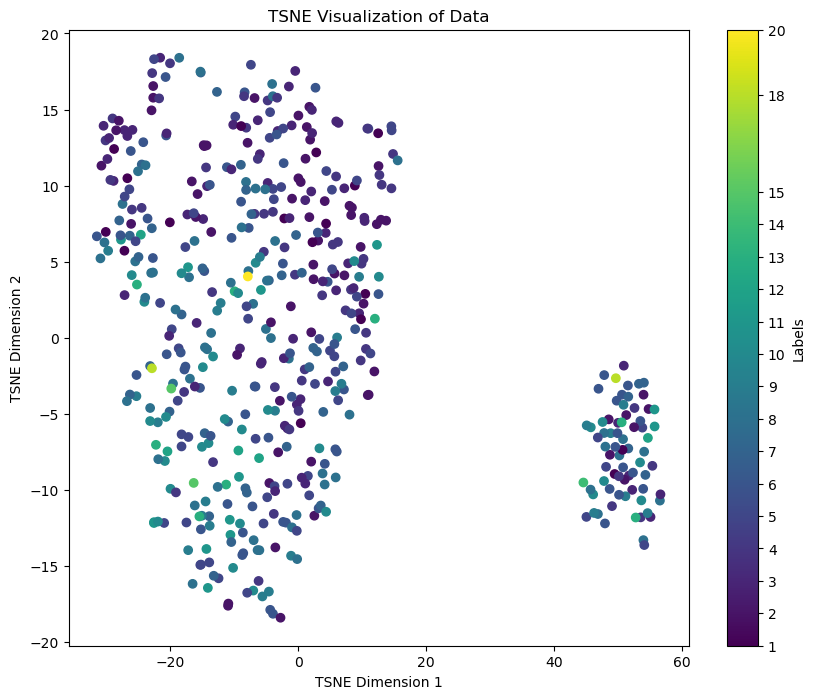

In [151]:
labels = np.squeeze(rf_data_array)

# Perform TSNE with 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(embeddings_array)

# Plotting
plt.figure(figsize=(10, 8))

# Scatter plot using the labels as color values
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='viridis')

# Add legend and labels
legend_labels = np.unique(labels)

# Add colorbar
cbar = plt.colorbar(scatter, ticks=legend_labels)
cbar.set_label('Labels')

plt.title('TSNE Visualization of Data')
plt.xlabel('TSNE Dimension 1')
plt.ylabel('TSNE Dimension 2')

# Show the plot
plt.show()

### Violin Plot

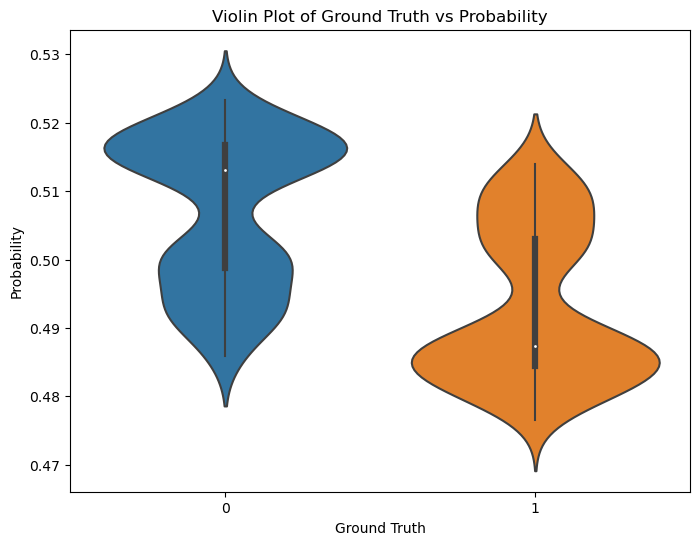

In [150]:
# Combine data into a Pandas DataFrame
data = pd.DataFrame({'Ground Truth': gt_data_array.flatten(), 'Probability': prob_data_array.flatten()})

# Create a violin plot using seaborn
plt.figure(figsize=(8, 6))
sns.violinplot(x='Ground Truth', y='Probability', data=data)
plt.xlabel('Ground Truth')
plt.ylabel('Probability')
plt.title('Violin Plot of Ground Truth vs Probability')
plt.show()

### Create folder for UNet

In [10]:
# import os
# import shutil

# def collapse_directory_images(source_dir, target_dir):
#     """
#     Move all images from source_dir and its subdirectories to target_dir.
    
#     Args:
#     - source_dir (str): Path to the source directory.
#     - target_dir (str): Path to the target directory where all images will be moved.
#     """
#     if not os.path.exists(target_dir):
#         os.makedirs(target_dir)
#         print(f"Created target directory {target_dir}")
    
#     for root, dirs, files in os.walk(source_dir):
#         for file in files:
#             if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
#                 source_path = os.path.join(root, file)
#                 target_path = os.path.join(target_dir, file)
                
#                 # if os.path.exists(target_path):
#                 #     print(f"Warning: {target_path} already exists and will be overwritten.")
                
#                 shutil.copy(source_path, target_path)
#                 # print(f"Moved {source_path} to {target_path}")

# # Example usage
# source_directory = 'C:/Users/m294666/Documents/11_14_23'
# target_directory = 'C:/Users/m294666/Documents/nevus_data_unet_training_inpainting'
# collapse_directory_images(source_directory, target_directory)

# def list_images(directory):
#     """Recursively list all image filenames in the directory."""
#     images = []
#     for root, dirs, files in os.walk(directory):
#         for file in files:
#             if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
#                 images.append(file)
#     return images

# def remove_duplicate_images(source_directory, target_directory):
#     """Remove images in source_directory if they exist in target_directory."""
#     target_images = set(list_images(target_directory))
    
#     for image in os.listdir(source_directory):
#         if image in target_images:
#             os.remove(os.path.join(source_directory, image))
#             print(f'Removed {image}')

# # Paths to your directories
# source_directory = 'C:/Users/m294666/Documents/nevus_data_unet_training_inpainting'
# target_directory = 'C:/Users/m294666/Documents/nevus_data_500_risk_factors'

# remove_duplicate_images(source_directory, target_directory)

### Stratified K-Fold

In [25]:
import os
import numpy as np
from sklearn.model_selection import StratifiedKFold

def extract_class_from_image_name(image_name, rf):
    rf_type = {'dia5':-6, 'intref':-5, 'orange':-4, 'va':-3, 'thick2':-2, 'srf':-1}
    rf = rf_type[rf]
    label = int(image_name.split('.')[0].split('_')[rf])
    return label

def determine_mrn_classes(main_directory, rf):
    """Determine the class of each MRN based on the first image in its directory."""
    mrn_classes = {}
    for mrn_folder in os.listdir(main_directory):
        mrn_path = os.path.join(main_directory, mrn_folder)
        if os.path.isdir(mrn_path):
            images = sorted(os.listdir(mrn_path))
            if images:
                reference_image = images[0]
                class_name = extract_class_from_image_name(reference_image, rf)
                mrn_classes[mrn_folder] = class_name
    return mrn_classes

def create_nested_stratified_folds(mrn_classes, outer_splits=5, inner_split_ratio=0.875):
    """Create nested stratified folds with a structure for train, validation, and test sets."""
    mrns = np.array(list(mrn_classes.keys()))
    classes = np.array(list(mrn_classes.values()))
    outer_skf = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=42)
    
    folds = []
    for trainval_index, test_index in outer_skf.split(mrns, classes):
        trainval_mrns, test_mrns = mrns[trainval_index], mrns[test_index]
        trainval_classes = classes[trainval_index]

        inner_skf = StratifiedKFold(n_splits=int(1/(1-inner_split_ratio)), shuffle=True, random_state=42)
        train_index, val_index = next(inner_skf.split(trainval_mrns, trainval_classes))

        train_mrns, val_mrns = trainval_mrns[train_index], trainval_mrns[val_index]
        
        folds.append([train_mrns.tolist(), val_mrns.tolist(), test_mrns.tolist()])
        
    return folds

# Example usage
main_directory = 'C:/Users/m294666/Documents/nevus_data_500_risk_factors_processed_RF_in_name_CF_only'
mrn_classes = determine_mrn_classes(main_directory, 'dia5')
print(len(mrn_classes))
folds = create_nested_stratified_folds(mrn_classes)

# Example output for verification
for i, fold in enumerate(folds):
    print(f"Fold {i+1}: Train MRNs: {len(fold[0])}, Val MRNs: {len(fold[1])}, Test MRNs: {len(fold[2])}")
    
folds[0]

384
Fold 1: Train MRNs: 268, Val MRNs: 39, Test MRNs: 77
Fold 2: Train MRNs: 268, Val MRNs: 39, Test MRNs: 77
Fold 3: Train MRNs: 268, Val MRNs: 39, Test MRNs: 77
Fold 4: Train MRNs: 268, Val MRNs: 39, Test MRNs: 77
Fold 5: Train MRNs: 269, Val MRNs: 39, Test MRNs: 76


[['10256854',
  '10503952',
  '10519507',
  '10524631',
  '10524639',
  '10541585',
  '10544859',
  '10547730',
  '10600503',
  '10615200',
  '10640409',
  '10649138',
  '10670236',
  '10688227',
  '12038360',
  '12060876',
  '12064804',
  '12069745',
  '12096431',
  '12170288',
  '12174367',
  '12177552',
  '12181910',
  '12186456',
  '12198868',
  '12252292',
  '12288673',
  '12327313',
  '1235617',
  '12365102',
  '12391550',
  '12488146',
  '12514595',
  '12600570',
  '12611275',
  '12672455',
  '12850353',
  '12867650',
  '12936150',
  '12960912',
  '12961843',
  '12975408',
  '13038662',
  '13049977',
  '13119192',
  '13129757',
  '13132523',
  '13223557',
  '13242130',
  '13276778',
  '13296201',
  '13322005',
  '13338530',
  '13376469',
  '13392077',
  '13410941',
  '13414918',
  '13426789',
  '13532820',
  '13547536',
  '13663484',
  '13726509',
  '13772735',
  '13803981',
  '13843011',
  '13953426',
  '1770547',
  '1812703',
  '1832926',
  '1862915',
  '2007399',
  '2205156',